## KLL Sketch Examples

### Basic Sketch Usage

In [1]:
from datasketches import kll_floats_sketch, kll_ints_sketch

Options are a `kll_floats_sketch` or `kll_ints_sketch`. We'll use the former so we can draw samples from a Gaussian distribution. We start by creating a sketch with $k=200$, which gives a normalized rank error of about 1.65%, and feeding in 1 million points.

In [2]:
n = 1000000
kll = kll_floats_sketch(200)
from numpy.random import randn
for i in range(0, n):
    kll.update(randn())    

Since the data is distributed as $\cal{N}(0,1)$, 0.0 should be near the median rank (0.5)

In [3]:
kll.get_rank(0.0)

0.497608

And the median should also be near 0.0

In [4]:
kll.get_quantile(0.5)

0.003108405973762274

We track the min and max values as well. They are stored separately from the quantile data so we can always determine the full _empirical_ data range. In this case they should be very roughly symmetric around 0.0. We can query these values explicitly, or implicitly by asking for the values at ranks 0.0 and 1.0.

In [5]:
[kll.get_min_value(), kll.get_max_value()]

[-4.6000142097473145, 4.779754638671875]

In [6]:
kll.get_quantiles([0.0, 1.0])

[-4.6000142097473145, 4.779754638671875]

And out of curiosity, we can check how many items the sketch has seen and how many it is retaining

In [7]:
kll.get_n()

1000000

In [8]:
kll.get_num_retained()

614

Finally, we can serialize the sketch for archiving, and reconstruct it later. Note that the serialized image does _not_ contain information on whether it is a floats or ints sketch.

In [9]:
sk_bytes = kll.serialize()
len(sk_bytes)

2536

In [10]:
kll2 = kll_floats_sketch.deserialize(sk_bytes)
print(kll2)

### KLL sketch summary:
   K              : 200
   min K          : 200
   M              : 8
   N              : 1000000
   Epsilon        : 1.33%
   Epsilon PMF    : 1.65%
   Empty          : false
   Estimation mode: true
   Levels         : 13
   Sorted         : true
   Capacity items : 617
   Retained items : 614
   Storage bytes  : 2536
   Min value      : -4.6
   Max value      : 4.78
### End sketch summary



### Merging Sketches

KLL sketches have a `merge()` operation to combine sketches. The resulting sketch will have no worse error boudns than if the full data had been sent to a single sketch.

Our previous sketch used $\cal{N}(0,1)$, so now we'll generate a shifted Gaussian distributed as $\cal{N}(4,1)$. For added variety, we can use half as many points. The next section will generate a plot, so we will defer queries of the merged skech to that section.

In [12]:
sk2 = kll_floats_sketch(200)
for i in range(0, int(n/2)):
    sk2.update(4 + randn())

In [13]:
kll.merge(sk2)
print(kll)

### KLL sketch summary:
   K              : 200
   min K          : 200
   M              : 8
   N              : 1500000
   Epsilon        : 1.33%
   Epsilon PMF    : 1.65%
   Empty          : false
   Estimation mode: true
   Levels         : 13
   Sorted         : false
   Capacity items : 617
   Retained items : 580
   Storage bytes  : 2400
   Min value      : -4.6
   Max value      : 9.06
### End sketch summary



### Generating Histograms

The KLL sketch allows us compute histograms via the probability mass function (pmf). Since histograms are a typical plot type when visualizing data distributions, we will create such a figure. To instead create a cumulative distribution function (cdf) from the sketch, simply replace the call to `get_pmf()` with `get_cdf()`.

We want our x-axis to have evenly distributed bins, so the first step is to split the empirical data range
into a set of bins.

In [14]:
xmin = kll.get_min_value()
num_splits = 30
step = (kll.get_max_value() - xmin) / num_splits
splits = [xmin + (i*step) for i in range(0, num_splits)]

`get_pmf()` returns the probability mass in the range $(x_{i-1}, x_i]$, for each bin $i$. If we use the minimum value for $x_{i-1}$ this covers the low end, but `get_pmf()` also returns an extra bin with all mass greater than the last-provided split point. As a result, the pmf array is 1 larger than the list of split points. We need to be sure to append a value to the split points for plotting.

In [15]:
pmf = kll.get_pmf(splits)
x = splits  # this will hold the x-axis values, so need to append the max value
x.append(kll.get_max_value())

We need some plotting-related imports and options

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

Using a negative width in the plot gives right-aligned bins, which matches the bin definition noted earlier.

<BarContainer object of 31 artists>

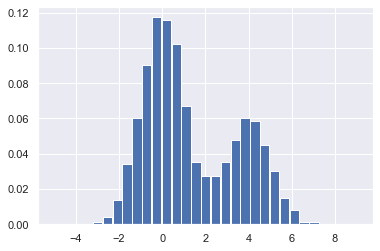

In [17]:
plt.bar(x=x,height=pmf,align='edge',width=-0.43)

The leftmost peak came from the first sketch, with data centered around 0.0. The smaller, rightmost peak came from our second sketch, which had half as many samples and was centered around 4.0. The KLL sketch captures the shape of the combiend distribution.